10080


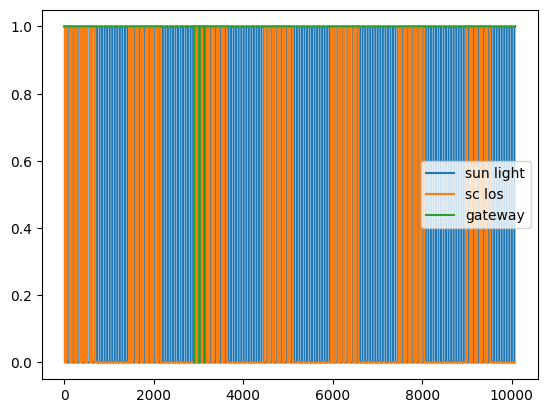

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

with open("tmp_week/som.pickle", 'rb') as f:
    sun_light_init = pickle.load(f)
f.close()
with open("tmp_week/los.pickle", "rb") as f:
    los_sc_init= pickle.load(f)
f.close()
with open("tmp_week/rd.pickle", "rb") as f:
    Rdl_init = pickle.load(f)
f.close()
with open("tmp_week/rs.pickle", "rb") as f:
    Rsc_init = pickle.load(f)
f.close()
with open("tmp_week/gwlos.pickle", "rb") as f:
    gw_los_init=pickle.load(f)
f.close()
with open("tmp_week/gwr.pickle", "rb") as f:
    gw_rate_init=pickle.load(f)
f.close()

N=len(sun_light_init)
print(N)
M=100
plt.step(range(N), sun_light_init, label="sun light")
plt.step(range(N), los_sc_init, label="sc los")
plt.step(range(N), gw_los_init, label="gateway")
plt.legend()
plt.show()

reduce data to end on the last sc los

[0, 692, 2164, 3636, 5107, 6578, 8050, 9522]


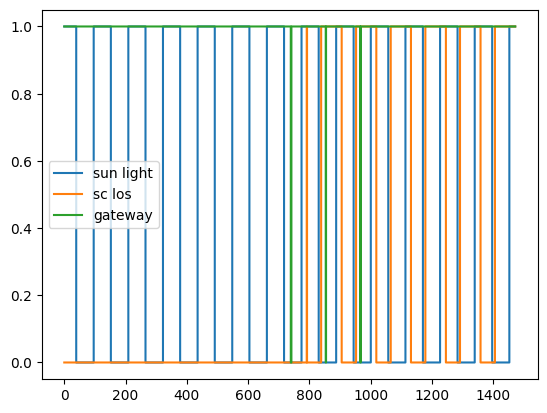

In [8]:

los_sc=los_sc_init

x=[0]+[1 if los_sc[i-1]==1 and los_sc[i]==0 else 0 for i in range(1,len(los_sc))]
burst_end=np.where(np.array(x) == 1)
z=[0]
for i in range(len(burst_end[0])-1):
    if burst_end[0][i+1]-burst_end[0][i]>600:
        z.append(burst_end[0][i])
z.append(burst_end[0][-1])
print(z)

day=2
falling_edge=np.cumsum([1 if los_sc[i]==1 and los_sc[i+1]==0 else 0 for i in range(len(los_sc))])
max_indent=np.argmax(falling_edge)+1
day_length=int(np.floor(len(sun_light_init)/7))
# sun_light=sun_light_init[day*day_length:(day+1)*day_length]
# los_sc=los_sc_init[day*day_length:(day+1)*day_length]
# gw_los=gw_los_init[day*day_length:(day+1)*day_length]
sun_light=sun_light_init[z[day]:z[day+1]]
los_sc=los_sc_init[z[day]:z[day+1]]
gw_los=gw_los_init[z[day]:z[day+1]]
# Rsc=Rsc_init[z[day]:z[day+1]]
Rsc=1.0
Rdl=1.0
Rgw=1.0
# Rdl=Rdl_init[z[day]:z[day+1]]
# Rgw=gw_rate_init[z[day]:z[day+1]]

N=len(sun_light)
plt.step(range(N), sun_light, label="sun light")
plt.step(range(N), los_sc, label="sc los")
plt.step(range(N), gw_los, label="gateway")
plt.legend()
plt.show()

reduce previous data

In [3]:
class DL_optimizer:
    def __init__(self, sos, los, GW_los, Rsc, Rdl, Rgw):
        if len(sos) != len(los):
            raise ValueError("Sunlight On Spacecraft (sos) must be same length as Line-Of-Sight (los)")
        self.length = len(los)
        self.sos = sos
        self.los = los
        self.GW_los=GW_los
        self.Rsc = Rsc
        self.Rdl = Rdl
        self.Rgw = Rgw
    
    def setup(self, M, buffersize, summ_diff):
        self.M = M
        self.buffersize = buffersize
        self.summ_diff = summ_diff
    
    def optimize(self, buffer):
        import cvxpy as cp
        M = self.M
        buffer_size = self.buffersize
        summ_diff = self.summ_diff
        sun_light = self.sos
        los_sc = self.los
        GW_los = self.GW_los
        N=self.length
        Rsc = self.Rsc
        Rdl = self.Rdl
        Rgw = self.Rgw

        # Decision variables
        T_sc = cp.Variable(N, boolean=True)
        T_dl = cp.Variable(N, boolean=True)
        T_idle = cp.Variable(N, boolean=True)
        T_gw = cp.Variable(N, boolean=True)
        # Rsc = cp.Variable(integer=True)
        # print(Rsc.value)
        

        # Constraints list
        constraints = []
        # constraints += [Rsc[t] >=0.0 for t in range(N)]


        # Constraint 1: can only collect data when there is sunligt
        
        constraints += [T_sc <= sun_light]
        constraints += [T_gw <= GW_los]
        constraints += [T_dl <= los_sc]

        # Constraint 2: Only one variable avaiable at each time step
        constraints += [(T_sc + T_dl + T_idle + T_gw == 1)]

        # Constraint 3: We cannot transmit what we have not scienced
        for t in range(1, N):
            constraints += [
                cp.multiply(cp.sum(T_dl[:t]), Rdl) + cp.multiply(cp.sum(T_gw[:t]), Rgw) <= cp.multiply(cp.sum(T_sc[:t]), Rsc) +buffer
            ]

        # Constraint 5: Buffer size must not be exceeded
        for t in range(1,N):
            constraints += [
                cp.multiply(cp.sum(T_sc[:t]), Rsc) + buffer - cp.multiply(cp.sum(T_dl[:t]), Rdl) -cp.multiply(cp.sum(T_dl[:t]), Rdl) <= buffer_size
            ]

        # Ground station cappin
        rising_edges = cp.Variable(N, boolean=True)
        falling_edges = cp.Variable(N, boolean=True)
        GS = cp.Variable(N, boolean=True)

        # All initial falling edges must be zero
        constraints += [falling_edges[:M] == False]

        for t in range(N - M):

            constraints += [falling_edges[t+M] == rising_edges[t]]

            # There can not be a negative amount of falling edges
            constraints += [(cp.sum(rising_edges[:t]) - cp.sum(falling_edges[:t])) >= 0]
            #There can not be more than one GS window at once
            constraints += [(cp.sum(rising_edges[:t]) - cp.sum(falling_edges[:t])) <= 1]



        constraints += [rising_edges[N-M:N] == False]
        


        for t in range(N):
            constraints += [GS[t] == cp.sum(rising_edges[:t]) - cp.sum(falling_edges[:t])]
        constraints += [T_dl <= GS]
        constraints += [GS >=0 ]


        # Objective: minimize total downlink usage
        #objective = cp.Minimize(cp.sum(GS) - sc_total)
        objective = cp.Maximize(cp.multiply(cp.sum(T_dl), Rdl)-0.1*cp.sum(GS)+0.5*cp.multiply(cp.sum(T_gw), Rgw))
        
        # Solve
        problem = cp.Problem(objective, constraints)
        print(cp.installed_solvers())

        # Ensure the CBC solver is installed
        problem.solve(solver=cp.CBC, verbose=True)  # Using the CBC solver as an alternative
        # problem.solve(solver=cp.GUROBI, verbose=True)

        # Output
        # print("Status:", problem.status)
        # print("Total cost (timeslots slots used):", problem.value)
        # print("Total cost (downlink slots used):", sum(T_dl.value))
        # print("Total downlined:", sum(T_dl.value * np.array(Rdl)))
        # print("Total scienced:", sum(T_sc.value * np.array(Rsc)))
        # for t in range(N):
        #     print(f"t={t}: T_sc={T_sc.value[t]:.0f}, T_dl={T_dl.value[t]:.0f}, T_idle={T_idle.value[t]:.0f}, GS={GS.value[t]}")

        return T_sc.value, T_dl.value, T_idle.value, GS.value, T_gw.value

In [4]:
optimizer = DL_optimizer(sun_light, los_sc, gw_los, Rsc, Rdl, Rgw)
optimizer.setup(M, 100, 20)
T_sc, T_dl, T_idle, GS, T_GW = optimizer.optimize(50)

['CBC', 'CLARABEL', 'CVXOPT', 'GLOP', 'GLPK', 'GLPK_MI', 'GUROBI', 'MOSEK', 'OSQP', 'PDLP', 'SCIP', 'SCIPY', 'SCS', 'XPRESS']
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 09 11:55:13 AM: Your problem has 5544 variables, 9402 constraints, and 0 parameters.
(CVXPY) May 09 11:55:14 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 09 11:55:14 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 09 11:55:14 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 09 11:55:14 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
---------------------

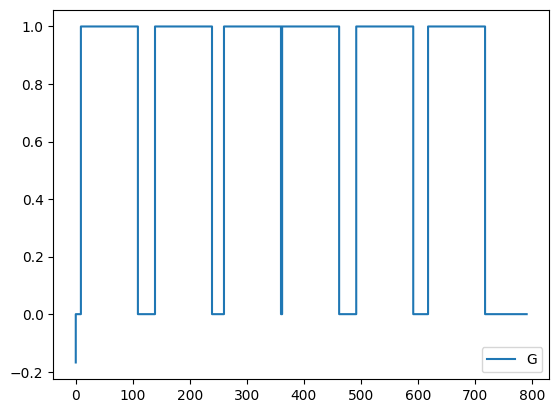

In [5]:
import matplotlib.pyplot as plt
import numpy as np
N=optimizer.length
g = np.empty(N, np.float16)
re = np.empty(N,np.float16)
fe = np.empty(N,np.float16)
for t in range(1,N):
    g[t] = GS[t]
    # re[t] = rising_edges.value[t]
    # fe[t] = falling_edges.value[t]
T = range(N)
plt.step(T, g, label = 'G')
# plt.step(T, re, label = 're')
# plt.step(T, fe, label='fe')
#plt.xlim(0,100)
plt.legend()
plt.show()

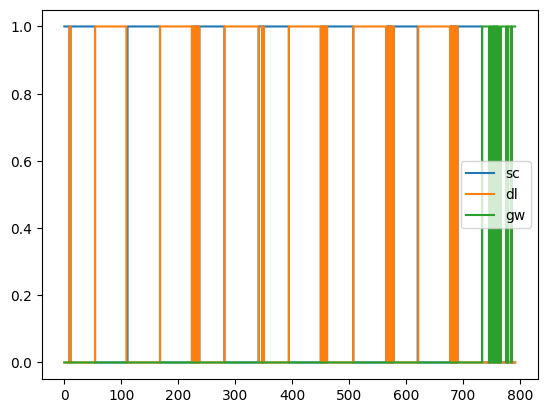

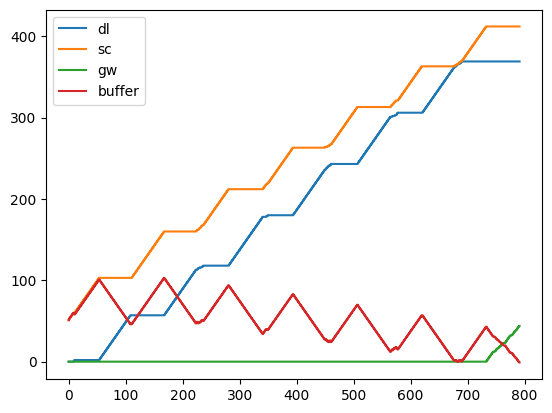

In [6]:

# sc = np.empty(N, np.float16)
# dl = np.empty(N, np.float16)
# for t in range(N):
#     sc[t] = T_sc[t]
#     dl[t] = T_dl[t]  # Extract values from T_dl
# sc_cumsum = np.cumsum(T_sc*Rsc)
# dl_cumsum = np.cumsum(T_dl*Rdl)
buffer=50
sc_cumsum = np.cumsum(T_sc)*Rsc+buffer
dl_cumsum = np.cumsum(T_dl)*Rdl
gw_cumsum = np.cumsum(T_GW)*Rgw

plt.step(range(len(T_dl)), T_sc, label = 'sc')
plt.step(range(len(T_dl)), T_dl, label = 'dl')
plt.step(range(len(T_dl)), T_GW, label = 'gw')
plt.legend()
plt.show()
plt.step(range(len(T_dl)), dl_cumsum, label = 'dl')
plt.step(range(len(T_dl)), sc_cumsum, label = 'sc')
plt.step(range(len(T_dl)), gw_cumsum, label = 'gw')
plt.step(range(len(T_dl)), sc_cumsum - gw_cumsum- dl_cumsum, label = 'buffer')
plt.legend()
plt.show()

In [7]:
# atoms = problem.atoms()
# for a in atoms:
#     print(a)
# constrain = problem.constraints
# for c in constrain:
#     print(c)